# Hemocyte Recruitment Analysis - Point pattern analyis

This notebook analyzes how close together the hemocytes appear in fed and starved abdomens by estimating - 
1. Pairwise distances between hemocytes
2. Nearest neighbor distances
3. G-function (cumulative distribution function of nearest neighbor distances)
4. Monte carlo simulation of G-function of fed and starved abdomens. 

Sections from the middle of the abdomen that are comparable across experimental groups are included. 

## Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from pathlib import Path
import glob
from scipy import stats
from scipy import spatial
sns.set_style('white')
sns.set(font_scale=1.5)

color_scheme = {"Fed": "dodgerblue","Starved": "darkorange"}

import warnings
warnings.filterwarnings('ignore')

## Set up input/output directories

In [2]:

base_path = Path("/Users/sbandya/Desktop/hemocyte_recruitment_image_quantification/")
outputs = base_path.joinpath('results','midsections')

hemocyte_coordinates = pd.read_csv(outputs.joinpath("hemocyte_coordinates_midsections.csv"), sep="\t",header=0)
abdomen_coordinates = pd.read_csv(outputs.joinpath("abdomen_coordinates_midsections.csv"), sep="\t",header=0) 

#Add experimental group info to hemocyte detections
image_condition = pd.Series(abdomen_coordinates.condition.values, index=abdomen_coordinates.Image).to_dict()
hemocyte_coordinates['condition'] = hemocyte_coordinates['Image'].map(image_condition)


## Estimate pairwise distances between hemocytes 

In [10]:
# Pairwise distances between points
fed_pairwise_distances = list()
starved_pairwise_distances = list()
for section in hemocyte_coordinates['Image'].unique():
    coords = hemocyte_coordinates[hemocyte_coordinates['Image'] == section][['centroid_x_zeroscaled','centroid_y_zeroscaled']].to_numpy()
    pairwise_distances = (spatial.distance.pdist(coords,'euclidean')).ravel()
    if hemocyte_coordinates[hemocyte_coordinates['Image'] == section]['condition'].unique()[0] == "Fed":
        fed_pairwise_distances.append(pairwise_distances)
    else:
        starved_pairwise_distances.append(pairwise_distances)

fed_pairwise_distances_flat = [i for ic in fed_pairwise_distances for i in ic]
starved_pairwise_distances_flat = [i for ic in starved_pairwise_distances for i in ic]

Text(0.5, 21.444444444444443, 'Hemocyte pairwise distances ($\\mu$m)')

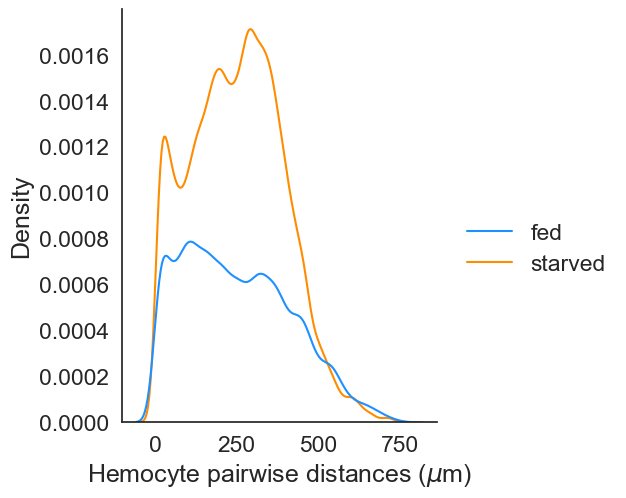

In [8]:
sns.set_style("white")

sns.displot({'fed' : fed_pairwise_distances_flat, 'starved' :starved_pairwise_distances_flat}, 
               palette=color_scheme.values(), kind="kde")
plt.xlabel("Hemocyte pairwise distances ($\mu$m)")

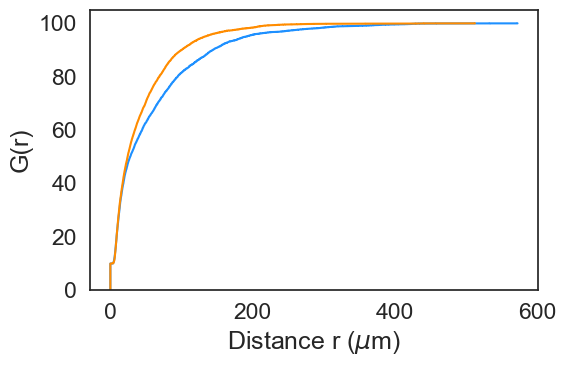

In [64]:
# Nearest neighbor distance
from sklearn.neighbors import NearestNeighbors

nn_distances_fed = list()
nn_distances_starved = list()

for section in hemocyte_coordinates['Image'].unique():
    coords = hemocyte_coordinates[hemocyte_coordinates['Image'] == section][['centroid_x_zeroscaled','centroid_y_zeroscaled']].to_numpy()
    nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(coords)
    distances, indices = nbrs.kneighbors(coords)
    if hemocyte_coordinates[hemocyte_coordinates['Image'] == section]['condition'].unique()[0] == "Fed":
        #sns.ecdfplot(distances[:,1],color="dodgerblue", stat="percent")
        #nn_distances_fed.append(distances[:,1])
        nn_distances_fed.append(distances.ravel())
        #print(distances.ravel())
    else:
       #sns.ecdfplot(distances[:,1],color="darkorange", stat="percent") 
        #nn_distances_starved.append(distances[:,1])
        nn_distances_starved.append(distances.ravel())
    #break

fig, ax = plt.subplots(figsize=(6,4))
nn_distances_fed_flat = [i for ic in nn_distances_fed for i in ic]
nn_distances_starved_flat = [i for ic in nn_distances_starved for i in ic]

sns.ecdfplot(nn_distances_fed_flat, color="dodgerblue",stat='percent', ax=ax)
sns.ecdfplot(nn_distances_starved_flat, color="darkorange",stat='percent',ax=ax)
ax.set_xlabel("Distance r ($\mu$m)")
ax.set_ylabel("G(r)")


fig.tight_layout()
fig.savefig(outputs.joinpath("gfunction.png"))

